In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import csv
import re
import time

### Scraping Data From Amazon

In [2]:
url = "https://www.amazon.in/s?i=apparel&bbn=206866169031&rh=n%3A1968255031%2Cp_85%3A10440599031%2Cp_36%3A-51000%2Cp_72%3A1318476031&s=review-rank&dc&hidden-keywords=-sponsored&ds=v1%3AvpJJ4RLmx4hQZe46icqqhxZVE2kFGE4o5RPBHzrq0Uo&pf_rd_i=1968253031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=f3a63277-7044-4783-a050-f67036bcca9c&pf_rd_r=AZ8CPNJGPX9EWVR3EAY2&pf_rd_s=merchandised-search-3&qid=1750863137&rnid=1318475031&ref=sr_nr_p_72_1"

In [3]:
header = ({"User-Agent" :"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/139.0.0.0 Safari/537.36", "Accept-Language" :'en-US,en;q=0.5'})

In [4]:
with open("amazon_products.csv", "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Product Name", "Price", "Brand Name", "Category", "MRP", "Rating", "Reviews", "Product URL"])

# Loop through pages 
    for page in range(1, 11):
        print(f"Scraping page {page}...")
        paged_url = url + f"&page={page}"
        webpage = requests.get(paged_url, headers=header)
        soup = BeautifulSoup(webpage.content, "html.parser")

        links = soup.find_all("a", attrs={'class': "a-link-normal s-line-clamp-2 s-line-clamp-3-for-col-12 s-link-style a-text-normal"})
        
        for a in links:
            link = a.get('href')
            if not link:
                continue

            product_url = "https://www.amazon.in" + link
            new_webpage = requests.get(product_url, headers=header)
            new_soup = BeautifulSoup(new_webpage.content, "html.parser")

# Product Name
            try:
                Product = new_soup.find("span", attrs={"id": "productTitle"}).text.strip()
            except:
                Product = "N/A"

# Sale Price
            try:
                Sale_price = new_soup.find("span", attrs={"class": "a-price-whole"}).text.strip()
            except:
                Sale_price = "N/A"

# Brand
            try:
                brand_tag = new_soup.find("a", attrs={"id": "bylineInfo"})
                if brand_tag:
                    Brand = brand_tag.text.strip()
                    Brand = Brand.replace("Visit the", "").replace("Store", "").replace("Brand:", "").strip()
                else:
                    Brand = "N/A"
            except:
                Brand = "N/A"

# MRP
            try:
                MRP = new_soup.find("span", attrs={"class": "a-price a-text-price"}).find("span", class_="a-offscreen").text.strip()
                MRP = re.sub(r"[^\d.]", "", MRP)
            except:
                MRP = "N/A"

# Rating
            try:
                Rating = new_soup.find("span", attrs={'class': "a-icon-alt"}).text.strip()
                Rating = re.search(r"[\d.]+", Rating).group()
            except:
                Rating = "N/A"

# Category
            try:
                category_links = new_soup.find_all("a", attrs={"class": "a-link-normal a-color-tertiary"})
                if category_links:
                    Category = category_links[-1].text.strip()
                else:
                    Category = "N/A"
            except:
                Category = "N/A"

# Reviews
            try:
                review_span = new_soup.find("span", attrs={'id': 'acrCustomerReviewText'})
                if review_span:
                    Reviews = re.sub(r"\D", "", review_span.get("aria-label", review_span.text))
                else:
                    Reviews = "N/A"
            except:
                Reviews = "N/A"

            writer.writerow([Product, Sale_price, Brand, Category, MRP, Rating, Reviews, product_url])
            
            time.sleep(1) 

Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...
Scraping page 8...
Scraping page 9...
Scraping page 10...


### Data 

In [2]:
data = pd.read_csv("amazon_products.csv")
data.head()

,Product Name,Price,Brand Name,Category,MRP,Rating,Reviews,Product URL
0,Leriya Fashion Women's Rayon Viscose Straight ...,509.0,Leriya Fashion,Kurtas & Kurtis,1999.0,4.9,64.0,https://www.amazon.in/Leriya-Fashion-LF-W-Kurt...
1,VastraVibes Women's Cotton Blend Printed Regul...,444.0,VastraVibes,Kurtas & Kurtis,1999.0,4.9,43.0,https://www.amazon.in/VastraVibes-Printed-kurt...
2,Leriya Fashion Women’s Sleeveless Rayon Kurta ...,479.0,Leriya Fashion,Kurtas & Kurtis,1999.0,4.8,80.0,https://www.amazon.in/Leriya-Fashion-LF-W-Kurt...
3,SHIENZY Cotton Blend Kurta Pant Set for Women ...,499.0,SHIENZY,Kurtas & Kurtis,3499.0,4.7,106.0,https://www.amazon.in/SHIENZY-Cotton-Teardrop-...
4,LERIYA FASHION Anarkali Kurta-Set for Women – ...,439.0,Leriya Fashion,Kurtas & Kurtis,1999.0,4.8,30.0,https://www.amazon.in/Leriya-Fashion-Printed-L...


In [3]:
# Discount percentage

data["Discount_percent"] = ((data["MRP"] - data["Price"])/data["MRP"])*100
data["Discount_percent"] = data["Discount_percent"].round(2)

In [4]:
# remove product discount percent less than 0
data = data[data['Discount_percent'] >= 0]

In [5]:
data.shape

(478, 9)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 478 entries, 0 to 479
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product Name      478 non-null    object 
 1   Price             478 non-null    float64
 2   Brand Name        478 non-null    object 
 3   Category          478 non-null    object 
 4   MRP               478 non-null    float64
 5   Rating            476 non-null    float64
 6   Reviews           476 non-null    float64
 7   Product URL       478 non-null    object 
 8   Discount_percent  478 non-null    float64
dtypes: float64(5), object(4)
memory usage: 37.3+ KB


In [7]:
# Sum of missing values in each column

data.isnull().sum()

Product Name        0
Price               0
Brand Name          0
Category            0
MRP                 0
Rating              2
Reviews             2
Product URL         0
Discount_percent    0
dtype: int64

In [8]:
# Drop missing values

data.dropna(subset=["Rating","Reviews"], inplace=True)

In [9]:
print("Duplicate values:",data.duplicated().sum())

Duplicate values: 0


In [10]:
data.dtypes

Product Name         object
Price               float64
Brand Name           object
Category             object
MRP                 float64
Rating              float64
Reviews             float64
Product URL          object
Discount_percent    float64
dtype: object

In [11]:
# Save the cleaned data

data.to_csv("Amazon_Products_cleaned.csv", index=False)

In [12]:
data.shape

(476, 9)

In [13]:
data.head()

,Product Name,Price,Brand Name,Category,MRP,Rating,Reviews,Product URL,Discount_percent
0,Leriya Fashion Women's Rayon Viscose Straight ...,509.0,Leriya Fashion,Kurtas & Kurtis,1999.0,4.9,64.0,https://www.amazon.in/Leriya-Fashion-LF-W-Kurt...,74.54
1,VastraVibes Women's Cotton Blend Printed Regul...,444.0,VastraVibes,Kurtas & Kurtis,1999.0,4.9,43.0,https://www.amazon.in/VastraVibes-Printed-kurt...,77.79
2,Leriya Fashion Women’s Sleeveless Rayon Kurta ...,479.0,Leriya Fashion,Kurtas & Kurtis,1999.0,4.8,80.0,https://www.amazon.in/Leriya-Fashion-LF-W-Kurt...,76.04
3,SHIENZY Cotton Blend Kurta Pant Set for Women ...,499.0,SHIENZY,Kurtas & Kurtis,3499.0,4.7,106.0,https://www.amazon.in/SHIENZY-Cotton-Teardrop-...,85.74
4,LERIYA FASHION Anarkali Kurta-Set for Women – ...,439.0,Leriya Fashion,Kurtas & Kurtis,1999.0,4.8,30.0,https://www.amazon.in/Leriya-Fashion-Printed-L...,78.04


### Data Analysis

In [14]:
# Find Descriptive statistics

data.describe()

,Price,MRP,Rating,Reviews,Discount_percent
count,476.000000,476.000000,476.000000,476.000000,476.000000
mean,444.008403,1829.464286,4.286555,195.350840,70.118782
std,67.985354,818.565333,0.303294,828.656951,16.394482
min,199.000000,499.000000,3.900000,3.000000,9.110000
25%,399.000000,1249.000000,4.000000,8.000000,65.045000
50%,474.000000,1825.000000,4.200000,21.000000,75.040000
75%,499.000000,2250.000000,4.500000,74.750000,80.800000
max,509.000000,4999.000000,5.000000,10120.000000,93.020000


In [15]:
# Top 5 brands

top_brands = data["Brand Name"].value_counts().head(5)
top_brands

Brand Name
Max                  28
Generic              26
JAIPUR HAND BLOCK    12
LIBOZA               12
ANNI DESIGNER        12
Name: count, dtype: int64

In [16]:
#brands which give the highest average discount

brand_discount = data.groupby('Brand Name')['Discount_percent'].mean().sort_values(ascending=False)
brand_discount.head()

Brand Name
FABNEX      89.7100
INDO ERA    89.0825
Kalaanj     89.0200
Manojava    88.1500
Hritika     86.8200
Name: Discount_percent, dtype: float64

In [17]:
# Find outliers product by price

Q1 = data["Price"].quantile(0.25)
Q3 = data["Price"].quantile(0.75)
IQR = Q3-Q1
price_outlier = data[(data['Price'] < Q1- 1.5 * IQR) | (data['Price'] > Q3 + 1.5 * IQR)]

product_outlier = price_outlier[["Product Name","Price"]]
product_outlier

,Product Name,Price
83,MF Hayat Women Ladies Rayon Embroidery Casul S...,199.0


In [18]:
# Product with low rating and high discount indicate Quality issue

low_rating = data[(data['Rating'] < 3) & (data['Discount_percent'] > 50)]
low_rating.size

0

### Data Visualization

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

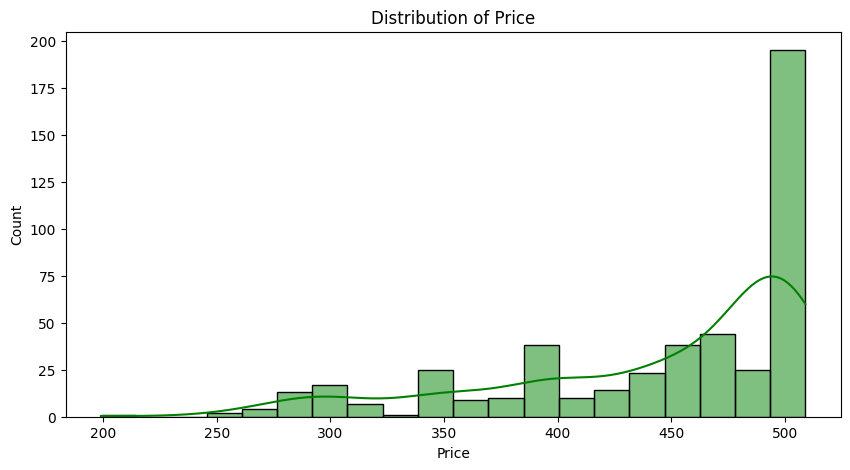

In [20]:
# Distribution of product price

plt.figure(figsize=(10,5))
sns.histplot(data["Price"], bins=20, kde=True, color="green")
plt.xlabel("Price")
plt.title("Distribution of Price")
plt.savefig("Distribution of Price.png", dpi=300, bbox_inches='tight') 
plt.show()

In [21]:
# Average discount percentage
avg_brand_discount = data.groupby('Brand Name', as_index=False)['Discount_percent'].mean()
avg_brand_discount = avg_brand_discount.sort_values(by='Discount_percent', ascending=False)


fig = px.bar(avg_brand_discount,
    x='Brand Name',
    y='Discount_percent',
    hover_data=['Discount_percent'],
    text='Discount_percent',
    color='Discount_percent',
    color_continuous_scale='Inferno')

fig.update_layout(
    title="Average Discount Percentage by Brand",
    xaxis_title="Brand",
    yaxis_title="Average Discount (%)",
    xaxis_tickangle=-45)
fig.write_image("avg_discount_by_brand.png", width=1200, height=1000, scale=2)

fig.show()

In [22]:
top10_avg_brand_discount = avg_brand_discount.head(10)

fig = px.bar(top10_avg_brand_discount,
    x='Brand Name',
    y='Discount_percent',
    hover_data=['Discount_percent'],
    text='Discount_percent',
    color='Discount_percent',
    color_continuous_scale='Inferno')

fig.update_layout(title="Top 10 Average Discount Percentage by Brand",
    xaxis_title="Brand",
    yaxis_title="Average Discount (%)",
    xaxis_tickangle=-45)
fig.write_image("Top 10 Average Discount Percentage by Brand.png", width=1200, height=600, scale=2)

fig.show()

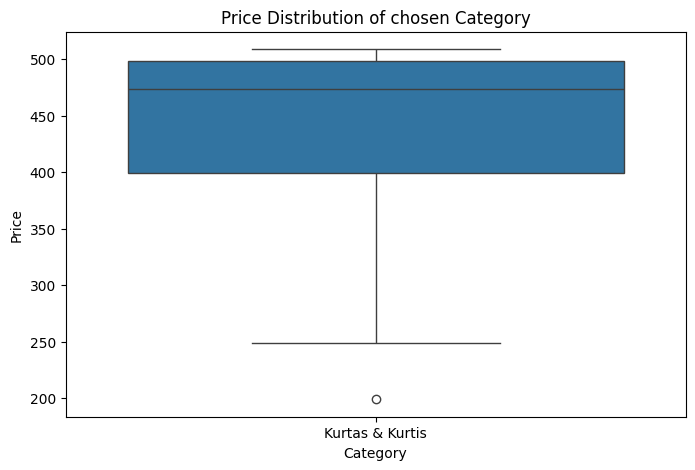

In [23]:
# Boxplot - Price Distribution of choosen category

plt.figure(figsize=(8,5))
sns.boxplot(x='Category', y='Price', data=data,)
plt.title('Price Distribution of chosen Category')
plt.xlabel('Category')
plt.ylabel('Price')
plt.savefig("Price Distribution of chosen category.png", dpi=300, bbox_inches='tight') 
plt.show()

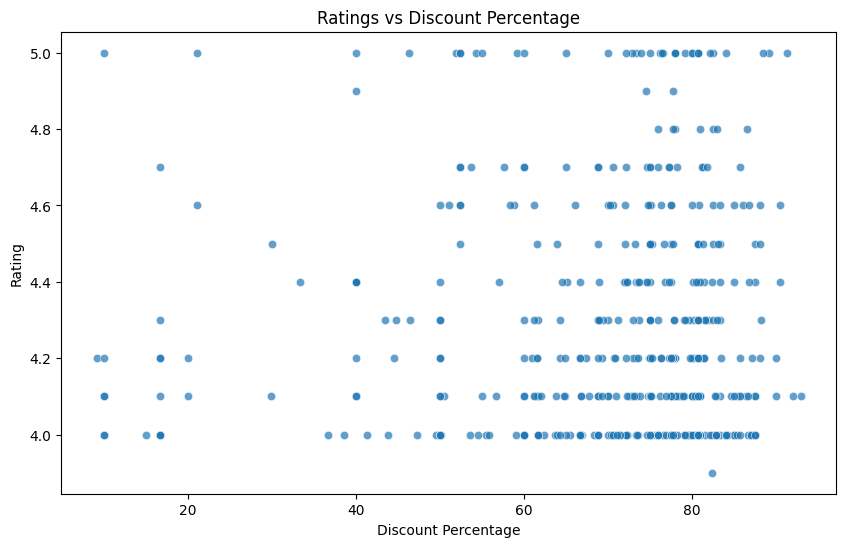

In [24]:
# Scatter plot of Ratings vs Discount Percentage

plt.figure(figsize=(10,6))
sns.scatterplot(x='Discount_percent', y='Rating', data=data,alpha=0.7)
plt.title('Ratings vs Discount Percentage')
plt.xlabel('Discount Percentage')
plt.ylabel('Rating')
plt.savefig("Ratings vs Discount Percentage.png", dpi=300, bbox_inches='tight') 
plt.show()

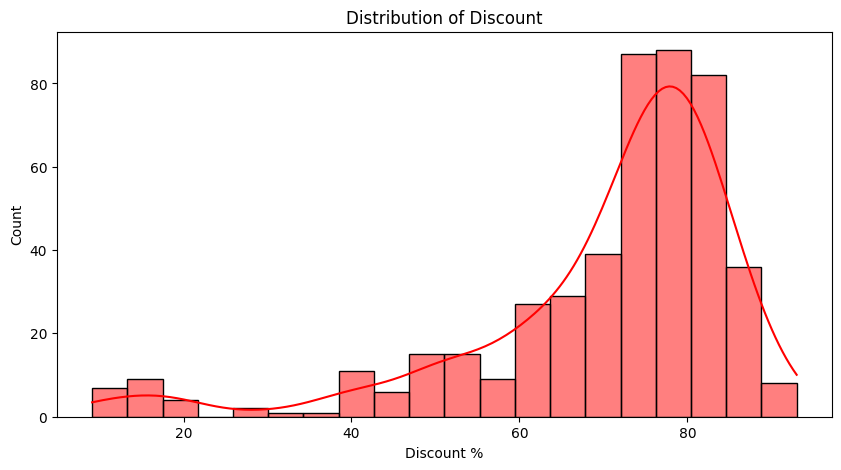

In [25]:
# Distribution of Discount 

plt.figure(figsize=(10,5))
sns.histplot(data["Discount_percent"], bins=20, kde=True, color="red")
plt.xlabel("Discount %")
plt.title("Distribution of Discount")
plt.savefig("Distribution of Discount.png", dpi=300, bbox_inches='tight') 
plt.show()

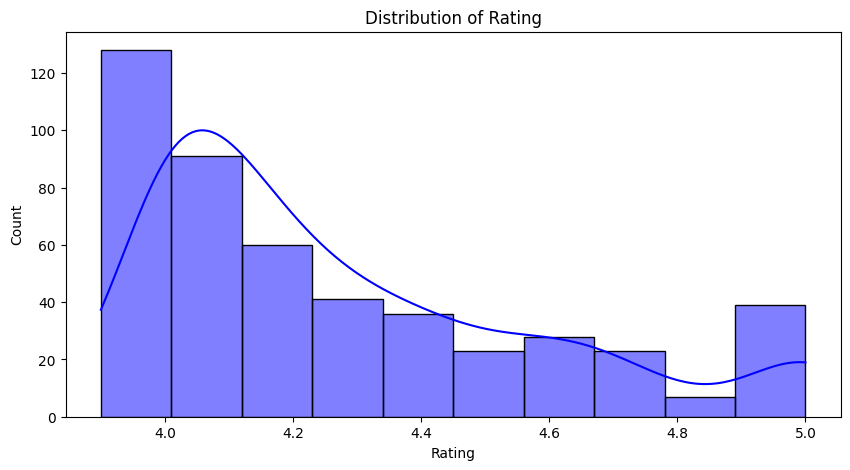

In [26]:
# Distribution of Rating

plt.figure(figsize=(10,5))
sns.histplot(data["Rating"], bins=10, kde=True, color="blue")
plt.xlabel("Rating")
plt.title("Distribution of Rating")
plt.savefig("Distribution of Rating.png", dpi=300, bbox_inches='tight') 
plt.show()

In [27]:
# Top 10 Brands by Average Rating
brand_rating = data.groupby("Brand Name")["Rating"].mean().reset_index().sort_values(by="Rating", ascending=False)
top10_brand_rating = brand_rating.head(10)

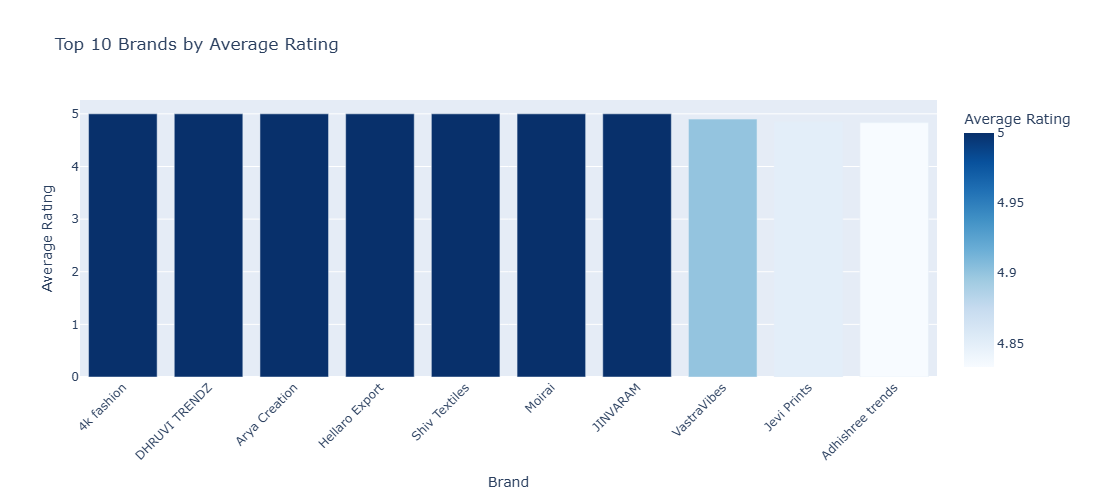

In [28]:
fig = px.bar(
    top10_brand_rating,
    x="Brand Name",
    y="Rating",
    title="Top 10 Brands by Average Rating",
    labels={"Rating": "Average Rating", "Brand Name": "Brand"},
    color="Rating",
    hover_data={"Brand Name": True, "Rating": True},
    color_continuous_scale="Blues")
fig.update_layout(xaxis_tickangle=-45, width=800, height=500)
fig.write_image("top10_brand_rating.png",scale=2)

fig.show()

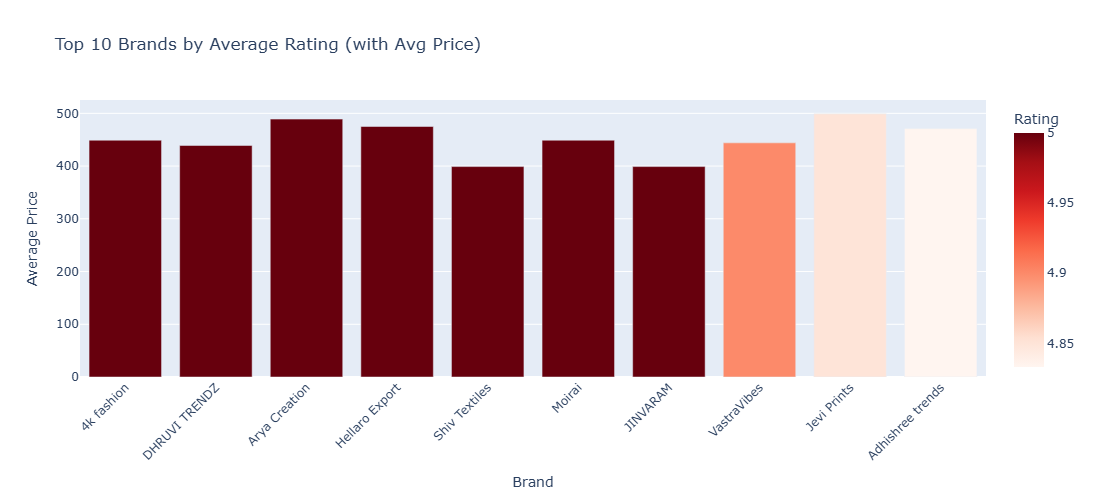

In [29]:
# Group by Brand Name → calculate average Rating & Price
brand_info = data.groupby("Brand Name").agg({"Price": "mean","Rating": "mean"}).reset_index()

# Sort by Rating and take top 10 brands
top10_brand_info = brand_info.sort_values(by="Rating", ascending=False).head(10)

fig = px.bar(
    top10_brand_info,
    x="Brand Name",
    y="Price",
    title="Top 10 Brands by Average Rating (with Avg Price)",
    labels={"Price": "Average Price", "Brand Name": "Brand"},
    color="Rating",   
    hover_data={"Brand Name": True, "Price": True, "Rating": True},
    color_continuous_scale="Reds")

fig.update_layout(xaxis_tickangle=-45, width=800, height=500)
fig.write_image("Top 10 Brands by Average Rating (with Avg Price).png",scale=2)
fig.show()

In [33]:
# top 10 product by Number of reviews
top10_products = data.sort_values(by="Reviews", ascending=False).head(10)

In [31]:
fig = px.bar(
    top10_products,
    x="Product Name",
    y="Reviews",
    title="Top 10 Products by Reviews",
    color="Reviews",
    color_continuous_scale="Greens",
    hover_data={"Price": True, "Rating": True, "Discount_percent": True})

fig.update_layout(width=1000,height=1000,xaxis_tickangle=-45,xaxis_title="Product",yaxis_title="Number of Reviews")
fig.write_image("Top 10 Products by Reviews.png",scale=2)
fig.show()
